In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
#
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
# from collections import namedtuple

from matplotlib.backends.backend_pdf import PdfPages

try:
    # for Python2
    from Tkinter import *   ## notice capitalized T in Tkinter 
except ImportError:
    # for Python3
    from tkinter import *   ## notice lowercase 't' in tkinter here

In [4]:
df=pd.read_csv('/home/flav/Mestrado/MHaJoL/data/results.csv', sep=',', encoding='utf-8-sig', header =[0])
df = df.loc[df['region'] == 'Generation'].drop(columns=['region'])
# aux = df.loc[df['method'] == 'scalar']
# aux.head(100)

# First of all, find the outliers!
dfQuantile1 = df.groupby(['grp', 'metric', 'method', 'selectivity']).quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear').reset_index()
dfQuantile1 = dfQuantile1.rename(index=str, columns={"value": "first"})

dfQuantile2 = df.groupby(['grp', 'metric', 'method',  'selectivity']).quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear').reset_index()
dfQuantile2 = dfQuantile2.rename(index=str, columns={"value": "third"})

dfQuantile = pd.merge(dfQuantile1, dfQuantile2, how='inner', on=['grp', 'metric', 'method', 'selectivity'])
dfQuantile['IQR'] = dfQuantile['third'] - dfQuantile['first']

dfAggMedian = df.groupby(['grp', 'metric', 'method', 'selectivity'], as_index = False).aggregate(np.median)
dfAggMedian = dfAggMedian.rename(index=str, columns={"value": "median"})
dfIQR = pd.merge(dfQuantile, dfAggMedian, how='inner', on=['grp', 'metric', 'method', 'selectivity'])
dfIQR = pd.merge(dfIQR, df, how='inner', on=['grp', 'metric', 'method', 'selectivity'])

dfIQR['calc1'] = dfIQR['first'] - (1.5 * dfIQR['IQR'])
dfIQR['calc2'] = dfIQR['third'] - (1.5 * dfIQR['IQR'])

dfIQR['values'] = np.where((dfIQR['value'] < (dfIQR['first'] - (1 * dfIQR['IQR']))) | (dfIQR['value'] < (dfIQR['third'] - (1 * dfIQR['IQR']))), dfIQR['value'], dfIQR['median'])

dfIQR = dfIQR.drop(columns=['value', 'first', 'third', 'IQR', 'median', 'calc1', 'calc2'])
dfIQR = dfIQR.rename(index=str, columns={"values": "value"})

dfAggAVG = dfIQR.groupby(['grp', 'metric', 'method',  'selectivity'], as_index = False).aggregate(['mean'])


In [5]:

dfAggMedian = df.drop(columns=['grp'])#.groupby(['metric', 'method', 'selectivity'], as_index = False).aggregate(np.median)
# dfAggMedian = dfAggMedian.rename(index=str, columns={"value": "median"})
# dfIQR = pd.merge(dfQuantile, dfAggMedian, how='inner', on=['metric', 'method', 'selectivity'])
# dfIQR = pd.merge(dfIQR, df, how='inner', on=['metric', 'method', 'selectivity'])

# dfIQR['values'] = np.where((dfIQR['value'] < (dfIQR['first'] - (1.5 * dfIQR['IQR']))) | (dfIQR['value'] > (dfIQR['third'] + (1.5 * dfIQR['IQR']))), dfIQR['median'], dfIQR['value'])

# dfIQR = dfIQR.drop(columns=['value', 'first', 'third', 'IQR', 'median'])
# dfIQR = dfIQR.rename(index=str, columns={"values": "value"})

dfAggAVG = dfAggMedian.groupby(['metric', 'method', 'selectivity'], as_index = False).aggregate(['mean'])
dfAggAVG.head(10)

value
                                            mean
metric       method    selectivity              
CAS_COUNT_RD avx2      10           12378.374587
                       20           11990.435644
                       30           12227.711221
                       40           12156.201320
                       50           11853.930693
                       60           12465.897690
                       70           11947.445545
                       80           12060.381188
                       90           10171.207921
             avx512256 10           11822.457096

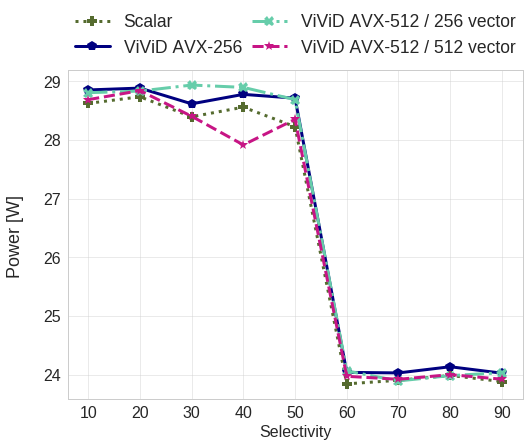

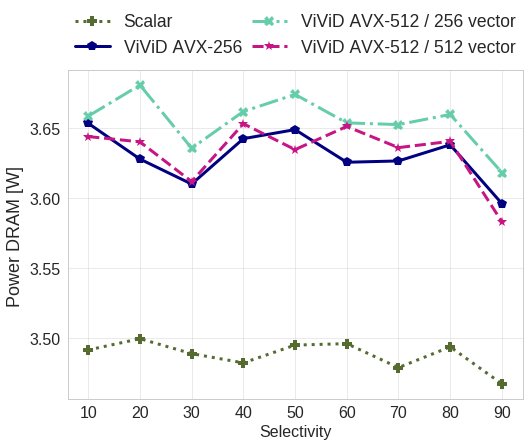

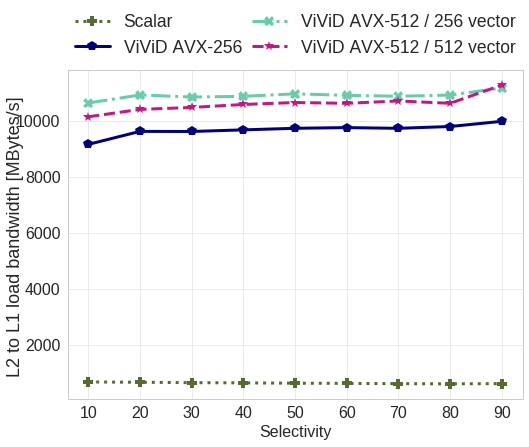

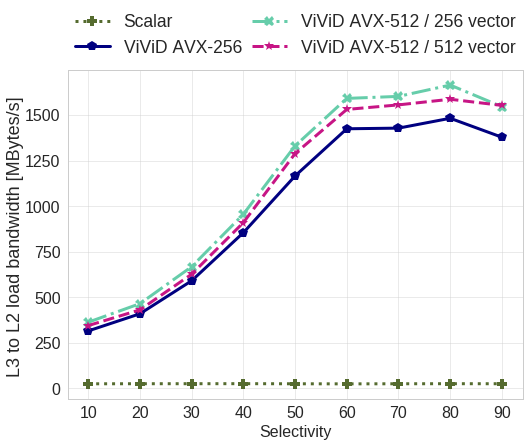

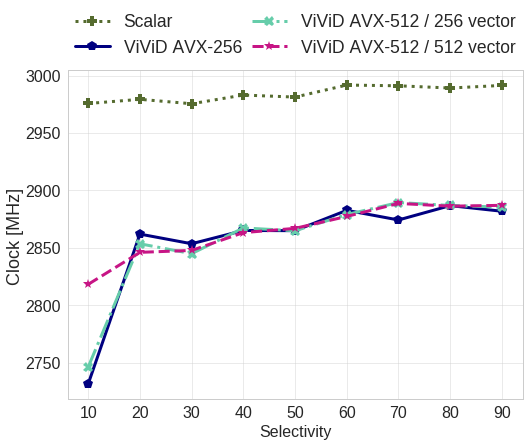

In [13]:
metrics=[('Power[W]', 'Power [W]'), 
('PowerDRAM[W]', 'Power DRAM [W]'),
# ('Memorywritebandwidth[MBytes_s]', 'Memory Write bandwidth [MBytes/s]'),
# ( 'Memoryreadbandwidth[MBytes_s]', 'Memory Read bandwidth [MBytes/s]'),
# ( 'Memorybandwidth[MBytes_s]', 'Memory bandwidth [MBytes/s]'),
# ('L2toL1loaddatavolume[GBytes]', 'L2 to L1 load data volume [GBytes]'),
('L2toL1loadbandwidth[MBytes_s]', 'L2 to L1 load bandwidth [MBytes/s]'),
# ('L3toL2loaddatavolume[GBytes]', 'L3 to L2 load data volume [GBytes]'),
('L3toL2loadbandwidth[MBytes_s]', 'L3 to L2 load bandwidth [MBytes/s]'),
# ('Memorydatavolume[GBytes]', 'Memory data volume [GBytes]'),
# ('RDTSCRuntime[s]', 'Build Time [ms]'),
('Clock[MHz]', 'Clock [MHz]')]



for (metric, yAxis) in metrics:
    dfFilter = dfAggAVG.xs(metric, level='metric')
       
    #X axis
    n_groups = 9
    index = np.arange(n_groups)
    
     # NP arrays of values
    dfMethod = dfFilter.xs("scalar", level='method')['value'].reset_index().sort_values('selectivity')
    dfValues = dfMethod["mean"]
    
    dfMethodVec = dfFilter.xs("avx2", level='method')['value'].reset_index().sort_values('selectivity')
    dfValuesVec = dfMethodVec["mean"]
    
    dfMethodVi = dfFilter.xs("avx512512", level='method')['value'].reset_index().sort_values('selectivity')
    dfValuesVi = dfMethodVi["mean"]

    dfMethodVi2 = dfFilter.xs("avx512256", level='method')['value'].reset_index().sort_values('selectivity')
    dfValuesVi2 = dfMethodVi2["mean"]

    #Style configs
    plt.style.use('seaborn-whitegrid')
    plt.rc('xtick',labelsize=16)
    plt.rc('ytick',labelsize=16)

    fig, ax = plt.subplots()
    ax.grid(alpha=0.4)

    fig.tight_layout()
    fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

    #Plot
    ax.plot(index, dfValues, color='darkolivegreen', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
    ax.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-256', linewidth=3,markersize=10)
    ax.plot(index, dfValuesVi2, color='mediumaquamarine', linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
    ax.plot(index, dfValuesVi, color='mediumvioletred', linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

    #Axis and labels
    ax.set_xlabel('Selectivity', fontsize=16)
    ax.set_xticklabels(('0', '10', '20', '30', '40', '50', '60', '70', '80', '90'))
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.,fancybox=True, fontsize=17.5)
    fig.text(0.1, 0.5, yAxis, ha='center', va='center', rotation='vertical', fontsize=18)

    plt.rcParams.update({'font.size': 18})

    #Draw and save
    plt.show()
    fig.savefig('/home/flav/Mestrado/MHaJoL/data/out/plots/'+metric+'.pdf', format='pdf', facecolor='white', edgecolor='none', bbox_inches='tight')
    fig.clf()

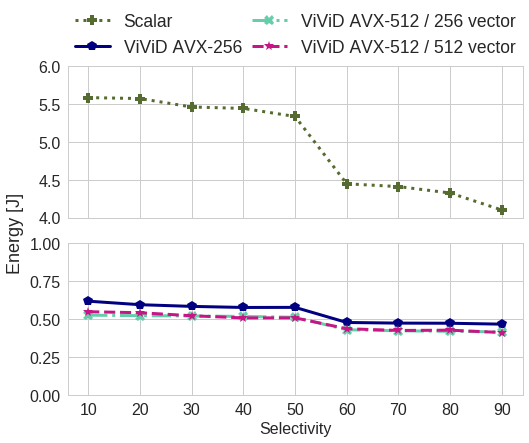

In [15]:
metrics=[('Energy[J]', 'Energy [J]')]
#           ('EnergyDRAM[J]', 'Energy DRAM [J]')]


for (metric, yAxis) in metrics:
    dfFilter = dfAggAVG.xs(metric, level='metric')
       
    #X axis
    n_groups = 9
    index = np.arange(n_groups)
    
     # NP arrays of values
    dfMethod = dfFilter.xs("scalar", level='method')['value'].reset_index().sort_values('selectivity')
    dfValues = dfMethod["mean"]
    
    dfMethodVec = dfFilter.xs("avx2", level='method')['value'].reset_index().sort_values('selectivity')
    dfValuesVec = dfMethodVec["mean"]
    
    dfMethodVi = dfFilter.xs("avx512512", level='method')['value'].reset_index().sort_values('selectivity')
    dfValuesVi = dfMethodVi["mean"]

    dfMethodVi2 = dfFilter.xs("avx512256", level='method')['value'].reset_index().sort_values('selectivity')
    dfValuesVi2 = dfMethodVi2["mean"]

    #Style configs
    #Style configs
    plt.style.use('seaborn-whitegrid')
    plt.rc('xtick',labelsize=16)
    plt.rc('ytick',labelsize=16)

    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)

    # fig, ax = plt.subplots()
    # ax.grid(alpha=0.4)
    # ax2.grid(alpha=0.4)

    fig.tight_layout()
    fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

    #Plot
    ax.plot(index, dfValues, color='darkolivegreen', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
    ax.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-256', linewidth=3,markersize=10)
    ax.plot(index, dfValuesVi2, color='mediumaquamarine', linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
    ax.plot(index, dfValuesVi, color='mediumvioletred', linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

    ax2.plot(index, dfValues, color='darkolivegreen', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
    ax2.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-256', linewidth=3,markersize=10)
    ax2.plot(index, dfValuesVi2, color='mediumaquamarine', linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
    ax2.plot(index, dfValuesVi, color='mediumvioletred', linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)
    
    #Axis and labels
    #Axis and labels
    ax2.set_xlabel('Selectivity', fontsize=16)
    ax.set_xticklabels(('0', '10', '20', '30', '40', '50', '60', '70', '80', '90'))
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.,fancybox=True, fontsize=17.5)
    fig.text(0.1, 0.5, yAxis, ha='center', va='center', rotation='vertical', fontsize=18)

    #Break the y axis
    ax.set_ylim(4, 6)  # outliers only
    ax2.set_ylim(0, 1)  # most of the data

    # ax.spines['bottom'].set_visible(False)
    # ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    # d = .015  # how big to make the diagonal lines in axes coordinates
    # # arguments to pass to plot, just so we don't keep repeating them
    # kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    # ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    # ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    # kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    # ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    # ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


    plt.rcParams.update({'font.size': 18})
    #Draw and save
    plt.show()
    fig.savefig('/home/flav/Mestrado/MHaJoL/data/out/plots/'+metric+'.pdf', format='pdf', facecolor='white', edgecolor='none', bbox_inches='tight')
    fig.clf()